In [349]:
# Import Libraries
from gurobi import *
import math
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import geopy.distance
from collections import defaultdict
from shapely.geometry import Point, LineString

# TEST Used for testing with a small sample
import random

In [350]:

# Load Polygons Data
polygons = gpd.read_file('../pandana/data/BGRI_2011/CONTINENTE/BGRI11_CONT.shp', dtype={'BGRI11': str})



# Load Distance Matrix - GEOMETRY is Coming as STRING
distanceMatrix = pd.read_csv('../pandana/data/distance_matrix_schools_ourem.csv', dtype={'to':str})
distanceMatrix = distanceMatrix.drop(columns=['geometry'])

## Start Here

In [351]:
# Load Projection Data
population_projection = pd.read_csv('./data_gettin/df_alunos_subseccao.csv', dtype={'Unnamed: 0':str})
population_projection.rename(columns={'Unnamed: 0':'BGRI'}, inplace=True)
population_projection.index = population_projection['BGRI']
population_projection = population_projection.drop(columns=['BGRI'])
# Aggregate 2 and 3 cicles
population_projection['proj_sum_2_3'] = population_projection.loc[:,"2_CEB_Proj_2040"]+population_projection.loc[:,"3_CEB_Proj_2040"]

In [352]:
population_projection['proj_sum_2_3'].sum()

2538.24

In [353]:
# Load School (Ofer) Data
schools = gpd.read_file('./data_gettin/escolasourem/gdf_escolas_Ourem2019_capacidades.shp')
# schools = gpd.read_file('./data_gettin/escolas_ourem_antigo/gdf_escolas_Ourem2019_capacidades.shp')
# schools.Capacidade = schools.Capacidade.astype(float)
schools['Capacida_2_3'] = schools.Capacida_2+schools.Capacida_3
schools['Alunos_2CE_3CE'] = schools.Alunos_2CE+schools.Alunos_3CE

In [354]:
# CHANGE MADE TO VERIFY JOANAS PROBLEM!
# schools.at[32,'Capacida_2_3'] = 728*1.25
# schools[schools['FID_x']==47].Capacida_2_3

In [355]:
# Small ADjust FOR TESTING PURPOSES
# schools[schools['FID_x']==47]
# 
# schools.at[32,'Capacida_4'] = 952
# schools[schools['FID_x']==47].Capacida_2_3


In [356]:
# Council Selection - for plotting purpuses
def get_required_bgri(column, value):
    return polygons[polygons[column]==value]

selectedPolygon = get_required_bgri('DTMN11', '1421')

In [357]:
schoolsPre.columns

Index(['school', 'id', 'FID_x', 'Elegiveis_', 'Nome_Escol', 'Codigo_DGE',
       'Salas_Pre_', 'Salas_1CEB', 'Salas_2CEB', 'Salas_3CEB', 'Salas_Sec',
       'FID_y', 'Elegivei_1', 'Nome_Esc_1', 'Codigo_D_1', 'Alunos_EPE',
       'Alunos_1CE', 'Alunos_2CE', 'Alunos_3CE', 'Alunos_Sec', 'Capacidade',
       'Capacida_1', 'Capacida_2', 'Capacida_3', 'Capacida_4', 'geometry',
       'Capacida_2_3', 'Alunos_2CE_3CE', 'dist_media', 'dist_min', 'dist_max',
       'dist_STDeviation', 'students'],
      dtype='object')

In [358]:
population_projection.columns

Index(['Pre_escolar_2011', '1_CEB_2011', '2_CEB_2011', '3_CEB_2011',
       'Secundario_2011', 'Code_Freg', 'Pre_escolar_percent', '1_CEB_percent',
       '2_CEB_percent', '3_CEB_percent', 'Secundario_percent',
       'Pre_escolar_Proj_2040', '1_CEB_Proj_2040', '2_CEB_Proj_2040',
       '3_CEB_Proj_2040', 'Secundario_Proj_2040', 'proj_sum_2_3'],
      dtype='object')

In [359]:
schools.columns

Index(['id', 'FID_x', 'Elegiveis_', 'Nome_Escol', 'Codigo_DGE', 'Salas_Pre_',
       'Salas_1CEB', 'Salas_2CEB', 'Salas_3CEB', 'Salas_Sec', 'FID_y',
       'Elegivei_1', 'Nome_Esc_1', 'Codigo_D_1', 'Alunos_EPE', 'Alunos_1CE',
       'Alunos_2CE', 'Alunos_3CE', 'Alunos_Sec', 'Capacidade', 'Capacida_1',
       'Capacida_2', 'Capacida_3', 'Capacida_4', 'geometry', 'Capacida_2_3',
       'Alunos_2CE_3CE'],
      dtype='object')

In [360]:
population_projection[["Pre_escolar_Proj_2040", "1_CEB_Proj_2040", "2_CEB_Proj_2040","3_CEB_Proj_2040","Secundario_Proj_2040"]].columns

Index(['Pre_escolar_Proj_2040', '1_CEB_Proj_2040', '2_CEB_Proj_2040',
       '3_CEB_Proj_2040', 'Secundario_Proj_2040'],
      dtype='object')

In [361]:
population_projection['Secundario_Proj_2040'] = population_projection.Secundario_Proj_2040*0.75

In [362]:
schools.Capacida_4.sum()

1652

In [363]:
# Define some school globals to make capacity calculation easier 
schoolSelection = 'Capacidade'
projectionSelection = 'Pre_escolar_Proj_2040'
studentsActualEnrolledSelection = 'Alunos_EPE'
schoolsPre = schools[schools[schoolSelection]>0]

# Used in Demand and Capacity
selectecProjection = population_projection.loc[:,projectionSelection]
selectedSchoolCapacity = schoolsPre.loc[ : , schoolSelection ]


In [364]:
# -------------- Decision Variables -------------- #

# School demand per BGRI
# demand = [15, 18, 14, 20]
# demand = dict(zip(population_projection.index,population_projection.Pre_escolar_Proj_2040))
demand = dict(zip(population_projection.index, selectecProjection))


# Plant capacity in thousands of units
# capacity = dict(zip(schoolsPre.index, schoolsPre.Capacidade))
# capacity = [20, 22, 17, 19, 5]
capacity = dict(zip(schoolsPre.index, selectedSchoolCapacity))

# Fixed costs for each plant
# fixedCosts = [12000, 15000, 17000, 13000, 16000]

# This would be operation Costs, if any were given. Right format would be a dict with school.index:school.cost
# fixedCosts = dict(zip(schools.index, schools.costs))
# fixedCosts = (schoolsPre.Capacidade/schoolsPre.Capacidade).values # This is the right one
# fixedCosts = (schoolsPre.Capacidade*1000).values


# Model
m = Model("capacitaded_location_schools")

# School open decision variables: open[p] == 1 if plant p is open.
open = m.addVars(list(capacity.keys()),
                 vtype=GRB.BINARY,
                 name="open")



In [365]:
# Transport To create Distance Matrix

transportCosts = []
notExistingBGRI = []

distanceMatrix_TD = list(zip(distanceMatrix.origin,distanceMatrix.to))
distanceMatrix_structure = dict(zip(distanceMatrix_TD,distanceMatrix.real_distance.values))

for bgri in demand:
    tempList = []
    for e in capacity:
        try:
            tempList.append(distanceMatrix_structure[(e,bgri)] * demand[bgri])
#             tempList.append(distanceMatrix_structure[(e,bgri)])
#             tempList.append(distanceMatrix[distanceMatrix['origin']==e][distanceMatrix['to']==bgri].real_distance.values[0])
        except:
            notExistingBGRI.append(bgri)
    transportCosts.append(tempList)
        

In [366]:
# Create Transport Decision Variables
transport = m.addVars(list(demand.keys()) ,list(capacity.keys()), obj=transportCosts,name="trans")

In [367]:
m.update()

In [368]:

# The objective is to minimize the total fixed and variable costs
m.modelSense = GRB.MINIMIZE

# Production constraints
# Note that the right-hand limit sets the production to zero if the plant
# is closed
m.addConstrs(
    (transport.sum('*',p) <= capacity[p] for p in list(capacity.keys())),
    "Capacity")

# Using Python looping constructs, the preceding would be...
#
#for p in plants:
#  m.addConstr(sum(transport[w][p] for w in warehouses) <= capacity[p] * open[p],
#              "Capacity[%d]" % p)

# Demand constraints
m.addConstrs(
    (transport.sum(w) == demand[w] for w in list(demand.keys())),
    "Demand")

# ... and the preceding would be ...
#for w in warehouses:
#  m.addConstr(sum(transport[w][p] for p in plants) == demand[w], "Demand[%d]" % w)

# Save model
m.write('facility_Pre.lp')



# First, open all plants
# for p in capacity:
#     open[p].start = 1.0

# # Now close the plant with the highest fixed cost
# print('Initial guess:')
# maxFixed = max(fixedCosts)
# for p in plants:
#     if fixedCosts[p] == maxFixed:
#         open[p].start = 0.0
#         print('Closing plant %s' % p)
#         break
# print('')

# Use barrier to solve root relaxation
m.Params.method = 2

# Solve
m.optimize()


Changed value of parameter method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Optimize a model with 1803 rows, 5403 columns and 10800 nonzeros
Variable types: 5400 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 7e+02]
Presolve removed 744 rows and 2235 columns
Presolve time: 0.01s
Presolved: 1059 rows, 3168 columns, 6336 nonzeros
Variable types: 3168 continuous, 0 integer (0 binary)
Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.168e+03
 Factor NZ  : 4.636e+03 (roughly 2 MBytes of memory)
 Factor Ops : 2.787e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.07036367e+08  0.00000000e+00  8.54e+03 7.28e-12  3.41e+05     0s
   1   5.71303311e+07 -2.43754188e+07  4.26e+02 1.33e+02

In [369]:

# Print solution
print('\nTOTAL COSTS: %g' % m.objVal)
print('SOLUTION:')
listOfCapacities = []
listOfSchoolAndBgri = []
enrolledStudentsCount = []
for p in capacity:
    
    if open[p].x < 0.99:
        print('School %s open' % p)
        tempList = []
        for w in demand:
            if transport[w,p].x > 0:
                print('  Transport %g units from BGRI %s' % \
                      (transport[w,p].x, w))
                # Create a list of School and BGRI and the distance to school
                listOfSchoolAndBgri.append([w,p,distanceMatrix_structure[p,w], distanceMatrix_structure[p,w]*transport[w,p].x])
                tempList.append(transport[w,p].x)
        
        print('SUM of School %d : %f' % (p, sum(tempList)))
        
        # To create a DF with school and number of students
        enrolledStudentsCount.append([p,sum(tempList)])
        # To verify if the correct number of students are enrolled
        listOfCapacities.append(sum(tempList))
            
    else:
        print('School is %s closed!' % p)
pd_SchoolAndBgri = pd.DataFrame(listOfSchoolAndBgri, columns=['BGRI','school','Unitary_real_distance','pondered_real_distance'])
pd_SchoolAndStudents = pd.DataFrame(enrolledStudentsCount, columns=['school', 'students'])


TOTAL COSTS: 1.34937e+07
SOLUTION:
School 20 open
  Transport 0.58478 units from BGRI 14210200101
  Transport 1.75434 units from BGRI 14210200104
  Transport 0.58478 units from BGRI 14210200105
  Transport 0.58478 units from BGRI 14210200107
  Transport 0.58478 units from BGRI 14210200111
  Transport 1.16956 units from BGRI 14210200112
  Transport 0.58478 units from BGRI 14210200113
  Transport 0.58478 units from BGRI 14210200114
  Transport 0.58478 units from BGRI 14210200117
  Transport 1.75434 units from BGRI 14210200118
  Transport 1.16956 units from BGRI 14210200119
  Transport 4.09346 units from BGRI 14210200207
  Transport 1.16956 units from BGRI 14210200208
  Transport 0.58478 units from BGRI 14210200209
  Transport 1.75434 units from BGRI 14210200210
  Transport 1.16956 units from BGRI 14210200211
  Transport 0.58478 units from BGRI 14210200216
  Transport 1.75434 units from BGRI 14210200221
  Transport 0.58478 units from BGRI 14210200222
  Transport 2.33912 units from BGRI 1

  Transport 0.573683 units from BGRI 14211100718
  Transport 0.573683 units from BGRI 14211100720
  Transport 0.573683 units from BGRI 14211100722
  Transport 0.573683 units from BGRI 14211100727
  Transport 0.573683 units from BGRI 14211100731
  Transport 0.573683 units from BGRI 14211100733
  Transport 0.573683 units from BGRI 14211100741
  Transport 0.573683 units from BGRI 14211100801
  Transport 1.72105 units from BGRI 14211100803
  Transport 0.573683 units from BGRI 14211100804
  Transport 0.573683 units from BGRI 14211100807
  Transport 0.573683 units from BGRI 14211100808
  Transport 0.573683 units from BGRI 14211100809
  Transport 0.573683 units from BGRI 14211100810
  Transport 1.72105 units from BGRI 14211100811
  Transport 1.14737 units from BGRI 14211100813
  Transport 1.14737 units from BGRI 14211100815
  Transport 1.14737 units from BGRI 14211100817
  Transport 2.29473 units from BGRI 14211100819
  Transport 0.573683 units from BGRI 14211100820
  Transport 2.29473 units 

  Transport 0.247065 units from BGRI 14211700123
  Transport 0.247065 units from BGRI 14211700125
  Transport 0.247065 units from BGRI 14211700128
  Transport 0.247065 units from BGRI 14211700131
  Transport 0.247065 units from BGRI 14211700132
SUM of School 21 : 185.375908
School 32 open
  Transport 1.998 units from BGRI 14210100101
  Transport 1.332 units from BGRI 14210100102
  Transport 1.332 units from BGRI 14210100103
  Transport 0.333 units from BGRI 14210100110
  Transport 0.333 units from BGRI 14210100111
  Transport 0.666 units from BGRI 14210100112
  Transport 0.333 units from BGRI 14210100113
  Transport 0.999 units from BGRI 14210100115
  Transport 1.665 units from BGRI 14210100118
  Transport 1.332 units from BGRI 14210100201
  Transport 3.996 units from BGRI 14210100202
  Transport 0.999 units from BGRI 14210100203
  Transport 1.665 units from BGRI 14210100208
  Transport 0.333 units from BGRI 14210100209
  Transport 0.333 units from BGRI 14210100210
  Transport 0.333 un

  Transport 0.256154 units from BGRI 14210800301
  Transport 0.256154 units from BGRI 14210800302
  Transport 0.512308 units from BGRI 14210800305
  Transport 0.512308 units from BGRI 14210800307
  Transport 0.256154 units from BGRI 14210800309
  Transport 0.256154 units from BGRI 14210800312
  Transport 0.512308 units from BGRI 14210800318
  Transport 0.256154 units from BGRI 14210800319
  Transport 0.512308 units from BGRI 14210800322
  Transport 0.256154 units from BGRI 14210800323
  Transport 0.768462 units from BGRI 14210800324
  Transport 0.768462 units from BGRI 14210800326
  Transport 0.768462 units from BGRI 14210800328
  Transport 0.768462 units from BGRI 14210800329
  Transport 0.256154 units from BGRI 14210800330
  Transport 0.256154 units from BGRI 14210800405
  Transport 0.512308 units from BGRI 14210800408
  Transport 0.512308 units from BGRI 14210800410
  Transport 0.512308 units from BGRI 14210800411
  Transport 0.256154 units from BGRI 14210800412
  Transport 0.256154

  Transport 1.72105 units from BGRI 14211100502
  Transport 0.573683 units from BGRI 14211100503
  Transport 1.14737 units from BGRI 14211100504
  Transport 1.14737 units from BGRI 14211100506
  Transport 0.573683 units from BGRI 14211100510
  Transport 1.14737 units from BGRI 14211100511
  Transport 0.573683 units from BGRI 14211100513
  Transport 0.573683 units from BGRI 14211100515
  Transport 0.573683 units from BGRI 14211100517
  Transport 1.72105 units from BGRI 14211100519
  Transport 0.573683 units from BGRI 14211100520
  Transport 0.573683 units from BGRI 14211100522
  Transport 4.58947 units from BGRI 14211100523
  Transport 0.573683 units from BGRI 14211100528
  Transport 0.573683 units from BGRI 14211100532
  Transport 0.573683 units from BGRI 14211100601
  Transport 0.573683 units from BGRI 14211100603
  Transport 1.14737 units from BGRI 14211100604
  Transport 1.14737 units from BGRI 14211100605
  Transport 1.72105 units from BGRI 14211100606
  Transport 1.14737 units fro

  Transport 0.57279 units from BGRI 14211500117
  Transport 1.71837 units from BGRI 14211500119
  Transport 1.14558 units from BGRI 14211500202
  Transport 0.57279 units from BGRI 14211500203
  Transport 2.86395 units from BGRI 14211500204
  Transport 0.57279 units from BGRI 14211500206
  Transport 0.57279 units from BGRI 14211500209
  Transport 1.14558 units from BGRI 14211500211
  Transport 1.14558 units from BGRI 14211500212
  Transport 2.86395 units from BGRI 14211500214
  Transport 1.14558 units from BGRI 14211500215
  Transport 0.57279 units from BGRI 14211500218
  Transport 1.14558 units from BGRI 14211500219
  Transport 1.14558 units from BGRI 14211500223
  Transport 1.14558 units from BGRI 14211500225
  Transport 0.57279 units from BGRI 14211500227
  Transport 2.29116 units from BGRI 14211500228
  Transport 1.71837 units from BGRI 14211500230
  Transport 1.71837 units from BGRI 14211500231
  Transport 1.14558 units from BGRI 14211500232
  Transport 3.43674 units from BGRI 1421

In [370]:
# Create the metrics from the pd with alocated demands and real_distance
schoolsPre['dist_media'] = pd_SchoolAndBgri[['school','Unitary_real_distance']].groupby('school').mean()
schoolsPre['dist_min'] = pd_SchoolAndBgri[['school','Unitary_real_distance']].groupby('school').min()
schoolsPre['dist_max'] = pd_SchoolAndBgri[['school','Unitary_real_distance']].groupby('school').max()
schoolsPre['dist_STDeviation'] = pd_SchoolAndBgri[['school','Unitary_real_distance']].groupby('school').std()


# Add to the selected schools how many students are alocated
schoolsPre = pd.merge(schoolsPre, pd_SchoolAndStudents[['students']], how='left', left_on=[schoolsPre.index], right_on=[pd_SchoolAndStudents.school])



/home/fillipe/anaconda3/envs/gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fillipe/anaconda3/envs/gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fillipe/anaconda3/envs/gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [371]:
schoolsPre

,key_0,id,FID_x,Elegiveis_,Nome_Escol,Codigo_DGE,Salas_Pre_,Salas_1CEB,Salas_2CEB,Salas_3CEB,...,Capacida_3,Capacida_4,geometry,Capacida_2_3,Alunos_2CE_3CE,dist_media,dist_min,dist_max,dist_STDeviation,students
0,20,0,27,1,37 - Centro de Estudos de Fátima,1421978,0,0,4,6,...,168,420,POINT (-45522.192 -3213.331),280,255,6609.561560,0.000,27557.948,4182.127942,415.960092
1,21,0,28,1,38 - Colégio de São Miguel de Fátima,1421117,0,0,5,7,...,196,504,POINT (-46818.063 -2929.745),336,384,12632.275729,189.732,27213.783,8707.624500,185.375908
2,32,0,47,1,"16 - EBS de Ourém (EB2,3/ES)",1421400,0,0,11,23,...,644,728,POINT (-38187.510 -881.624),952,501,9373.851859,162.409,25345.250,6009.168203,728.000000


In [372]:
pd_SchoolAndBgri[['school','Unitary_real_distance']].groupby('school').mean()

,Unitary_real_distance
school,
20,6609.561560
21,12632.275729
32,9373.851859


In [373]:
# clean after merge
schoolsPre = schoolsPre.rename(columns={'key_0':'school'})
schoolsPre.index = schoolsPre.school

In [374]:
schoolsPre

,school,id,FID_x,Elegiveis_,Nome_Escol,Codigo_DGE,Salas_Pre_,Salas_1CEB,Salas_2CEB,Salas_3CEB,...,Capacida_3,Capacida_4,geometry,Capacida_2_3,Alunos_2CE_3CE,dist_media,dist_min,dist_max,dist_STDeviation,students
school,,,,,,,,,,,,,,,,,,,,,
20,20,0,27,1,37 - Centro de Estudos de Fátima,1421978,0,0,4,6,...,168,420,POINT (-45522.192 -3213.331),280,255,6609.561560,0.000,27557.948,4182.127942,415.960092
21,21,0,28,1,38 - Colégio de São Miguel de Fátima,1421117,0,0,5,7,...,196,504,POINT (-46818.063 -2929.745),336,384,12632.275729,189.732,27213.783,8707.624500,185.375908
32,32,0,47,1,"16 - EBS de Ourém (EB2,3/ES)",1421400,0,0,11,23,...,644,728,POINT (-38187.510 -881.624),952,501,9373.851859,162.409,25345.250,6009.168203,728.000000


In [375]:
sum(listOfCapacities)

1329.335999999999

In [376]:
population_projection.Pre_escolar_Proj_2040.sum()

1006.1280000000002

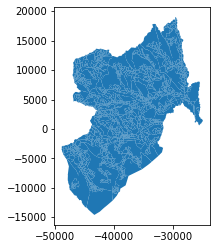

In [377]:
selectedPolygon.plot()

### PLOT the results

In [378]:
prePolygonLines = pd.merge(selectedPolygon, pd_SchoolAndBgri, how='left', left_on=[selectedPolygon.BGRI11], right_on=[pd_SchoolAndBgri.BGRI])
# Some BGRI are missing, or the demand is zero
prePolygonLines = prePolygonLines[prePolygonLines['school'].notna()]
prePolygonLines.school = prePolygonLines.school.astype(int)
prePolygonLines.geometry = prePolygonLines.centroid

In [379]:
# Get List of lines
listOfLines = []

for e in prePolygonLines.iterrows():
    pointSchool = [schoolsPre[schoolsPre.index==e[1].school].geometry.x.values[0], schoolsPre[schoolsPre.index==e[1].school].geometry.y.values[0]]
    line = LineString([[e[1].geometry.x, e[1].geometry.y],pointSchool])
    listOfLines.append(line)
prePolygonLines['line'] = listOfLines

In [380]:
teste = prePolygonLines
teste.geometry = teste.line

In [381]:
schoolsPre.students = schoolsPre.students.fillna(0)

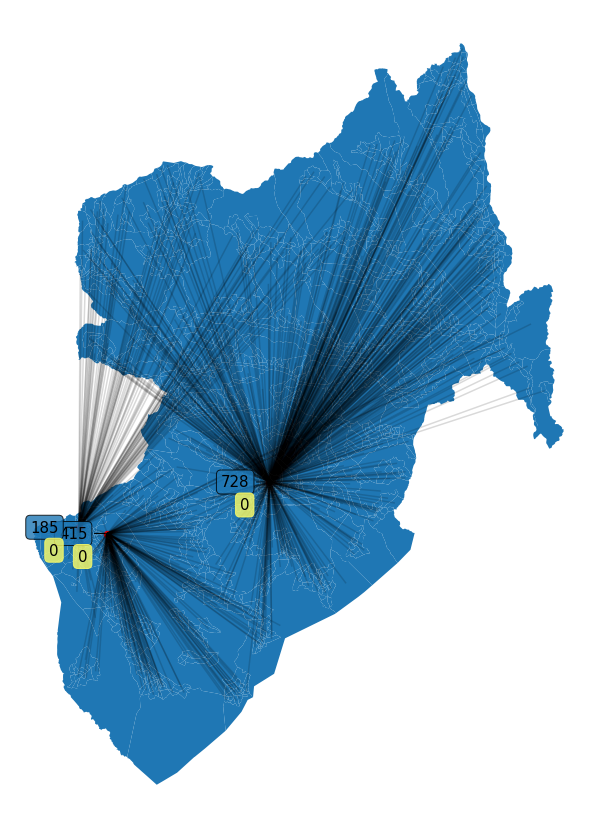

In [382]:
fig, ax = plt.subplots(figsize=(15,15))
teste.plot(ax=ax, alpha=0.15, color='black')

selectedPolygon.plot(ax=ax)
ax.set_axis_off()

for idx, row in schoolsPre.iterrows():
    offset = {'x':-20, 'y':0}
    
    ax.annotate(int(row['students']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row['Capacidade']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#FFFF66')
             );
    


schoolsPre.plot(ax=ax, markersize=40, color='red', marker='o', label='centroid')

### Plot Routine For Ourem

In [383]:
# # Códido maluco do Jan

# # Load Data
gdf_freguesias_CAOP2018 = gpd.read_file('../pandana/data/ourem_map_data/gdf_Freguesias_CAOP2018_Ourem.shp')
gdf_freguesias_CAOP2018 = gdf_freguesias_CAOP2018[gdf_freguesias_CAOP2018['code_mun']=='1421']
gpd_COS_municipio = gpd.read_file('../pandana/data/ourem_map_data/gpd_COS_Ourem.shp')
gdf_open_street2019_municipio = gpd.read_file('../pandana/data/ourem_map_data/gdf_open_street2019_Ourem.shp')


# _-------------_ Uso do Solo: Categorias _-----------_


#recebe RGB em dicionários de float e devolve o hexadecimal correspondente
def rgb_to_hex (diccionario_cores): 
    dict_novo = {}
    for nome in diccionario_cores:
        dict_novo [nome] = '#%02x%02x%02x'%tuple(int(i * 255) for i in diccionario_cores[nome])
    return(dict_novo)
#define RGB para cada tipo de ocupação de solo 
colors_cos = {'Territórios artificializados': (0.8, 0, 0),
              'Agricultura': (0.9, 0.7, 0.03), 
              'Pastagens': (0.96, 0.93, 0.03),
              'Sistemas agro-florestais': (0.85, 0.6, 0),
              'Florestas': (0, 0.5, 0), 
              'Matos': (0, 0.7, 0),
              'Espaços descobertos ou com vegetação esparsa': (0.9, 0.9, 0.5),
              'Zonas húmidas': (0.9, 0.9, 0.5), 
              'Corpos de água': (0.3, 0.6, 1)}
colors_cos_hexa = rgb_to_hex(colors_cos)


# _-------------_ Estradas: Categorias _-----------_

motorway = ['motorway', 'motorway_link']
primary = ['primary', 'trunk', 'secondary']
n_mapear = ['cycleway', 'steps', 'track','track_grade1','track_grade2',
            'track_grade3','track_grade4','track_grade5','pedestrian',
            'footway', 'unclassified','path']

dict_temp = {}
for nome in gdf_open_street2019_municipio.fclass.unique(): 
    if nome in motorway:
        dict_temp [nome] = list((0.4,6))
    elif nome in primary: 
        dict_temp [nome] = list((0.3,4))
    elif nome in n_mapear:
        dict_temp [nome] = list((0.2,1))
    else: 
        dict_temp [nome] = list((0.3,2))



### Plot the Capacitaded Model Result

/home/fillipe/anaconda3/envs/gurobi/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
No handles with labels found to put in legend.


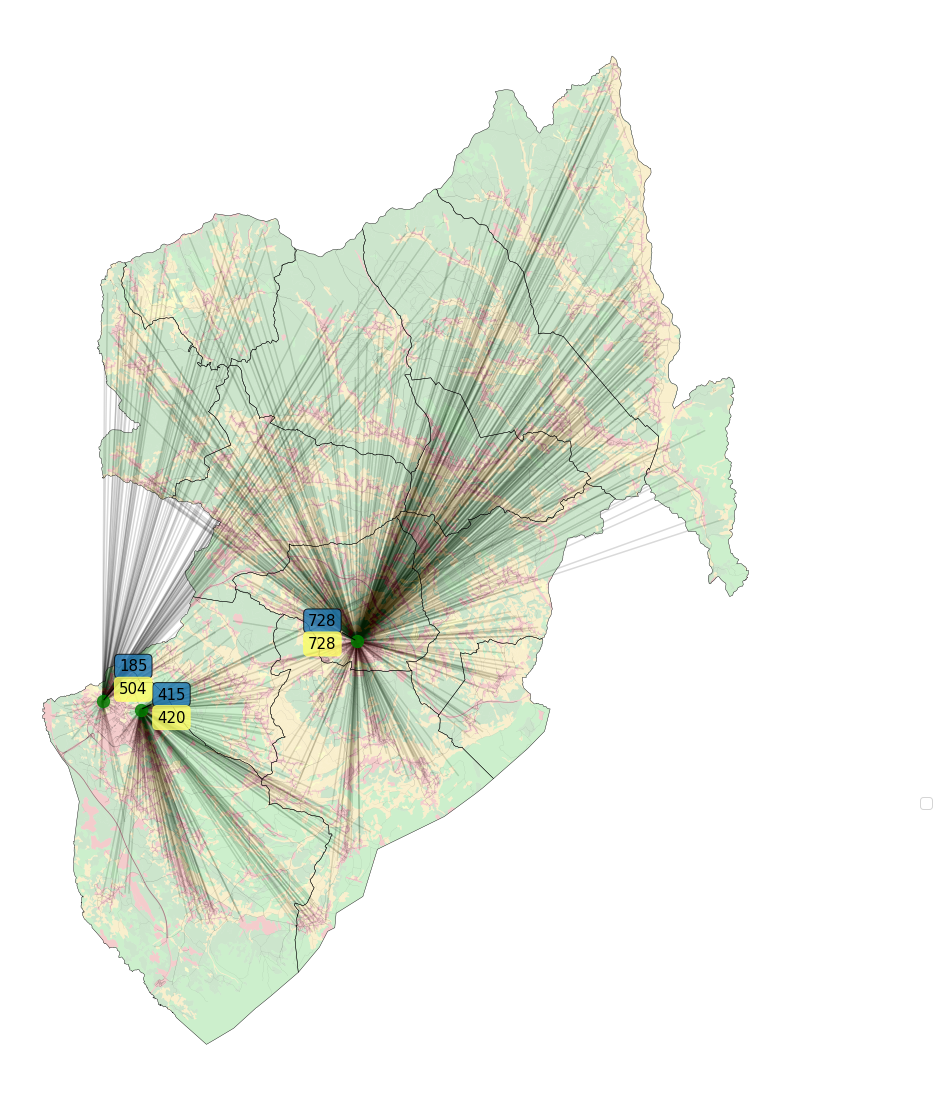

In [384]:
# _-------------_ Criação do Gráfico _-----------_
fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)


#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)
    
teste.plot(ax=ax, alpha=0.15, color='black')


ax.set_axis_off()

markersize = 150
# If the School has critic mass
schoolsPre.plot(ax=ax, markersize=markersize, color='green', marker='o', alpha=0.8,zorder=50)
# IF the school is a closing Candidate
schoolsPre[schoolsPre['students']<=22].plot(ax=ax, markersize=markersize, color='#FFA500', marker='s', label='Equipamento com menos de 21 alunos', alpha=0.8, zorder=60)
plt.legend(prop={'size':15}, bbox_to_anchor = (1.2,0.28))


for idx, row in schoolsPre.iterrows():
    offset = {'x':-20, 'y':0}
    
    
    # Offset Correction
    offset = {'x':45, 'y':-15} if idx==38 else offset
    offset = {'x':45, 'y':-15} if idx==36 else offset
    offset = {'x':45, 'y':-15} if idx==27 else offset
    offset = {'x':45, 'y':35} if idx==13 else offset
    offset = {'x':0, 'y':-30} if idx==22 else offset
    offset = {'x':45, 'y':15} if idx==20 else offset # 2_3
    offset = {'x':45, 'y':35} if idx==21 else offset # 2_3
    offset = {'x':20, 'y':-35} if idx==10 else offset # 2_3
    offset = {'x':-20, 'y':20} if idx==32 else offset # 2_3
    ax.annotate(int(row['students']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8),
             arrowprops=dict(arrowstyle="-", alpha=1));
    ax.annotate(int(row[schoolSelection]), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-23), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='#FFFF66')
             );
    

# 1000 is the magic number
# schoolsPre.plot(ax=ax, markersize=150, color='green', marker='o', label='centroid', alpha=0.8, zorder=1000)

### Plot the current over Projected number of students

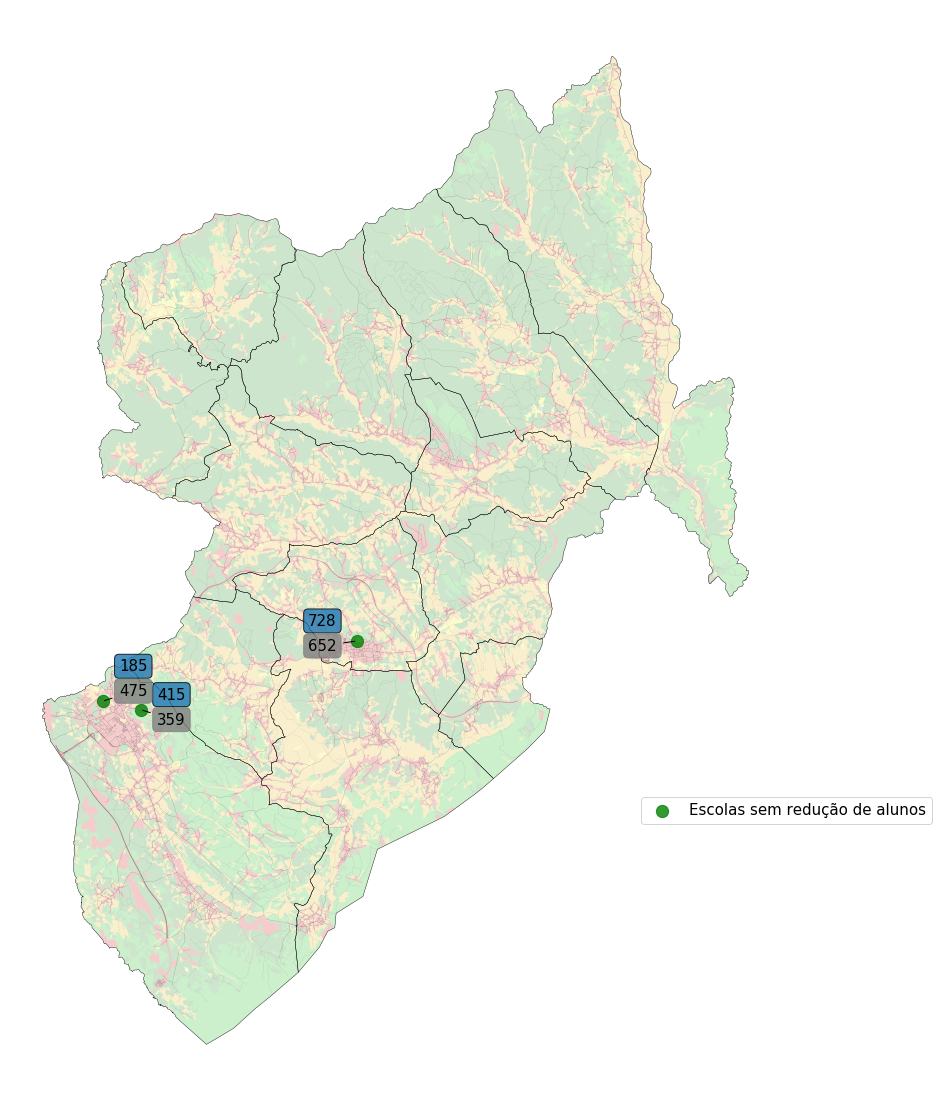

In [385]:
# _-------------_ Criação do Gráfico _-----------_
fig, ax = plt.subplots(figsize=(20, 20))

#Plota os limites das freguesias 
gdf_freguesias_CAOP2018.plot(ax=ax,
                        facecolor='None', edgecolor='black', linewidth=0.4, zorder=20)


#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gpd_COS_municipio.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2, zorder=10)

#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019_municipio.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=alpha, 
              linewidth=linewidth, zorder=15)
    
# teste.plot(ax=ax, alpha=0.15, color='black')


ax.set_axis_off()

markersize = 150
# If the School has critic mass
schoolsPre.plot(ax=ax, markersize=markersize, color='green', marker='o', alpha=0.8,zorder=50, label='Escolas sem redução de alunos')

# schoolsPre[schoolsPre.students<schoolsPre.loc[:,studentsActualEnrolledSelection]].plot(ax=ax, markersize=markersize, color='#B22222', marker='s', label='Escola com redução de alunos', alpha=0.8, zorder=60)

# IF the school is a closing Candidate
plt.legend(prop={'size':15}, bbox_to_anchor = (1.2,0.28))


for idx, row in schoolsPre.iterrows():
    offset = {'x':-20, 'y':0}
    
    
    # Offset Correction
    offset = {'x':45, 'y':-15} if idx==38 else offset
    offset = {'x':45, 'y':-15} if idx==36 else offset
    offset = {'x':45, 'y':-15} if idx==27 else offset
    offset = {'x':45, 'y':35} if idx==13 else offset
    offset = {'x':0, 'y':-30} if idx==22 else offset
    offset = {'x':45, 'y':15} if idx==20 else offset # 2_3
    offset = {'x':45, 'y':35} if idx==21 else offset # 2_3
    offset = {'x':20, 'y':-35} if idx==10 else offset # 2_3
    offset = {'x':-20, 'y':20} if idx==32 else offset # 2_3
    
    ax.annotate(int(row['students']), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8)
             );
    ax.annotate(int(row[studentsActualEnrolledSelection]), xy=(row['geometry'].x,row['geometry'].y),
             xytext=(offset['x'], offset['y']-25), textcoords='offset points',
             size=15, ha='right', va="center",zorder=200,
             bbox=dict(boxstyle="round", alpha=0.8, color='gray'),
             arrowprops=dict(arrowstyle="-", alpha=1));
    

# 1000 is the magic number
# schoolsPre.plot(ax=ax, markersize=150, color='green', marker='o', label='centroid', alpha=0.8, zorder=1000)

In [386]:
schoolsPre.to_excel(schoolSelection + '.xls')

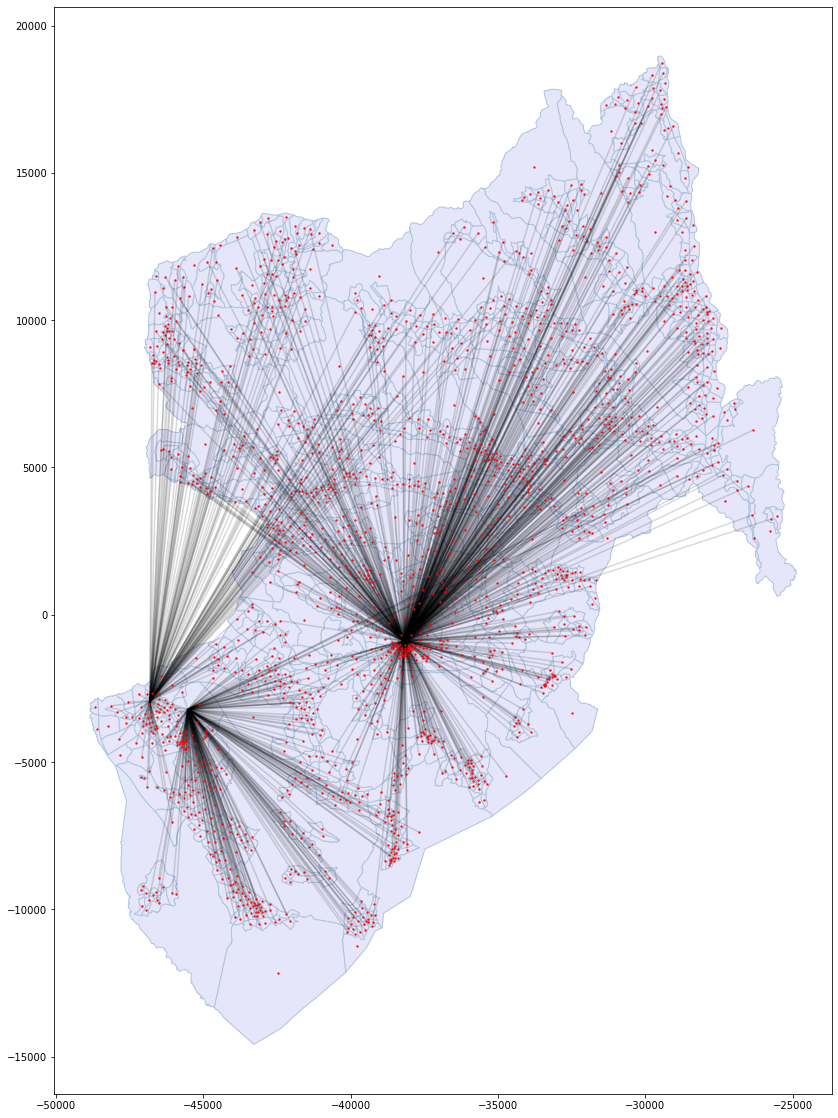

In [387]:

fig, ax = plt.subplots(figsize=(20, 20))
teste.plot(ax=ax, alpha=0.15, color='black')
selectedPolygon.centroid.plot(ax=ax, alpha=0.8, markersize=2, color='red',zorder=100)
selectedPolygon.plot(ax=ax,facecolor='#E6E6FA', edgecolor='#B0C4DE', )

# schoolsPre.plot(ax=ax, alpha=0.8, zorder=2000,color='blue', markersize=80)


In [388]:
pd_SchoolAndBgri[['school','pondered_real_distance']].groupby('school').sum().pondered_real_distance.sum()

7539919.411264879

In [389]:
pd_SchoolAndBgri[['school','Unitary_real_distance']].groupby('school').sum().Unitary_real_distance.sum()

9947719.312999995